# Fase 7 EDR: Visualización de experimentos

Los datos **no son una tabla agregada**. Si ves el archivo *summary* de test y train, es parte de las variables, y un csv. Ese csv contiene lo que parece ser una serie temporal con datos sobre el el estado del aterrizaje en cada instante de tiempo.

## EL PLAN
Necesitamos analizar las series temporales para sacar información sobre ellas, y agregarlas a los datos del excel para poder llevar a cabo una **regressión**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from f7utils import *
from typing import List, TypeVar, NewType, Tuple

# Creaate the np array type without the nptyping library
NDArray = NewType("NDArray", np.ndarray)

Estructura de la carpeta:

In [2]:
!tree . -L 2 | head

.
├── data
│   ├── CheckLandingV2.csv
│   ├── CheckLandingV2test.csv
│   ├── datos.zip
│   ├── experiments_summary_test.xlsx
│   ├── experiments_summary_train.xlsx
│   ├── metadata.txt
│   ├── test
│   └── train


---

## Visualizacion de experimentos
El EDA consisitirá de dos partes:
1. Ver como podemos sacar información valiosa sobre los experimentos
2. Ver como podemos agregar esa información a los xlsx

### Herramientas de limpieza y visualización
Veremos qué información útil podemos sacar de estas series temporales

Exploraremos primero uno de los CSV

In [3]:
exp1 = pd.read_csv('data/train/experiment_1.csv')
exp1.tail()

,x_pos,y_pos,x_vel,y_vel,angle,ang_vel,leg_1,leg_2,main_booster,lat_booster
181,-0.019154,-0.000078,3.208921e-08,-8.263651e-10,0.010104,-9.295870e-08,1.0,1.0,-0.805837,0.085813
182,-0.019154,-0.000078,8.139656e-10,-1.154962e-09,0.010104,-9.564672e-09,1.0,1.0,-0.920978,0.154106
183,-0.019154,-0.000078,-2.477457e-08,-9.659399e-10,0.010104,6.116299e-08,1.0,1.0,-0.927008,-0.070478
184,-0.019154,-0.000078,-3.645077e-08,-6.210173e-10,0.010104,9.317984e-08,1.0,1.0,-0.671896,0.145986
185,-0.019154,-0.000078,0.000000e+00,0.000000e+00,0.010104,0.000000e+00,1.0,1.0,-0.671896,0.145986


In [4]:
print(f"El experimento 1 tiene {exp1.shape[0]} filas")

El experimento 1 tiene 186 filas


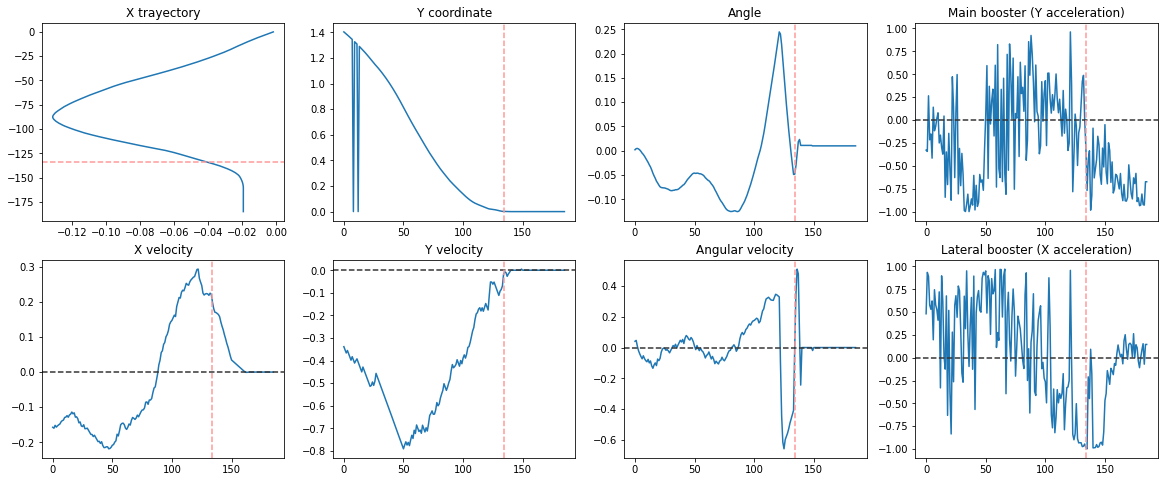

In [5]:
plotExperiment(exp1)

Suponemos que *leg_1* y *leg_2* solo valen 1 si está tocando el suelo

#### Fallo de muestra en la posición Y
Aparentemente en el primer experimento la nave cae exageradamente dos veces. Esto probablemente se deba a errores de medida:

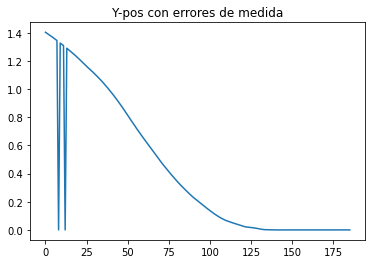

In [6]:
plt.plot(exp1.y_pos)
plt.title("Y-pos con errores de medida")
plt.show()

In [7]:
exp1.loc[exp1.y_pos == 0]

,x_pos,y_pos,x_vel,y_vel,angle,ang_vel,leg_1,leg_2,main_booster,lat_booster
8,-0.013675,0.0,-0.138264,-0.397028,-0.011219,-0.072471,0.0,0.0,-0.070441,0.579112
12,-0.019034,0.0,-0.124044,-0.406973,-0.028917,-0.099780,0.0,0.0,-0.163217,-0.330018


Nos hemos dado cuenta de que los dos puntos en los que la posición con respecto a __Y__ es igual a 0 se debe a malas lecturas. Si nos fijamos, las velocidades con respecto a ambos ejes y el resto de variables no han cambiado drásticamente como para alcanzar el suelo de golpe.

In [8]:
exp1["y_pos"][1]

1.3953845500946045

Así que lo que haremos es coger la anterior y siguiente medida de la posición $y$, y haremos la media de ambas para suavizar los errores.

In [9]:
exp1 = smoothY_pos(exp1)

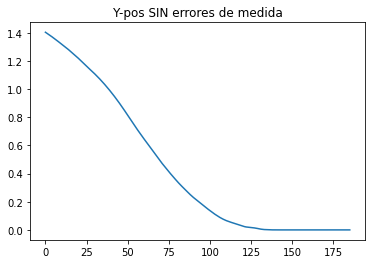

In [10]:
# plot y_pos again
plt.plot(exp1.y_pos)
plt.title("Y-pos SIN errores de medida")
plt.show()

---

## Ejemplo de Experimento malo
Vamos a analizar un experimento que ha obtenido una eficiencia muy mala para ver si podemos ver patrones

WARNING There has been an exception when trying to find the landing position

Landing position lines will not be plotted!



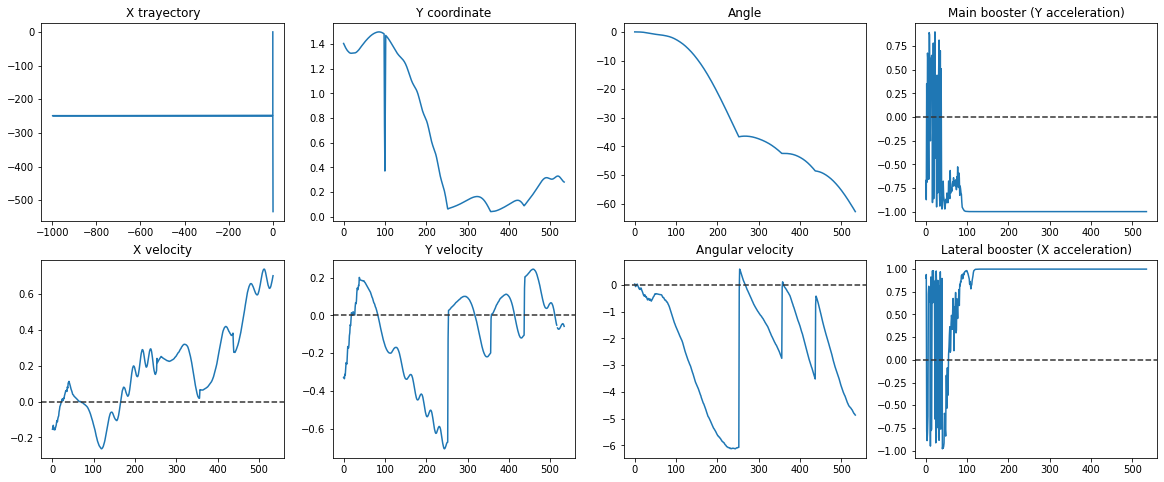

In [11]:
expbad = smoothY_pos(pd.read_csv('data/train/experiment_10010.csv'))
plotExperiment(expbad)

In [12]:
print(f"The number of times the first leg of the spaceship touched the ground were {np.sum(expbad.leg_1)}")
print(f"The number of times the second leg of the spaceship touched the ground were {np.sum(expbad.leg_2)}")

The number of times the first leg of the spaceship touched the ground were 0.0
The number of times the second leg of the spaceship touched the ground were 44.0


Este experimento lo hemos cogido aposta para ver cómo es el experimento que PEOR ha sido valorado en cuanto a eficiencia. De este destaca:
* El valor de la posición X es erróneo e implausible.
* La posición Y no termina en 0
* Que la primera pierna de la nave nunca llega a tocar el suelo
* Tiene un número de observaciones inusualmente largo
* La velocidad de Y no es cero cuando termina el experimento
* La velocidad angular tampoco es cero cuando termina el experimento
* El ángulo no queda en una posición fija

---

## Ejemplo de Experimento Bueno
Lo mismo que con el experimento malo, vamos analizar el experimento mejor valorado en cuanto a eficiencia.
Da la casualidad que el experimento mejor valorado es el primero, que ya tenemos cargado, asi que sólo queda analizarlo:

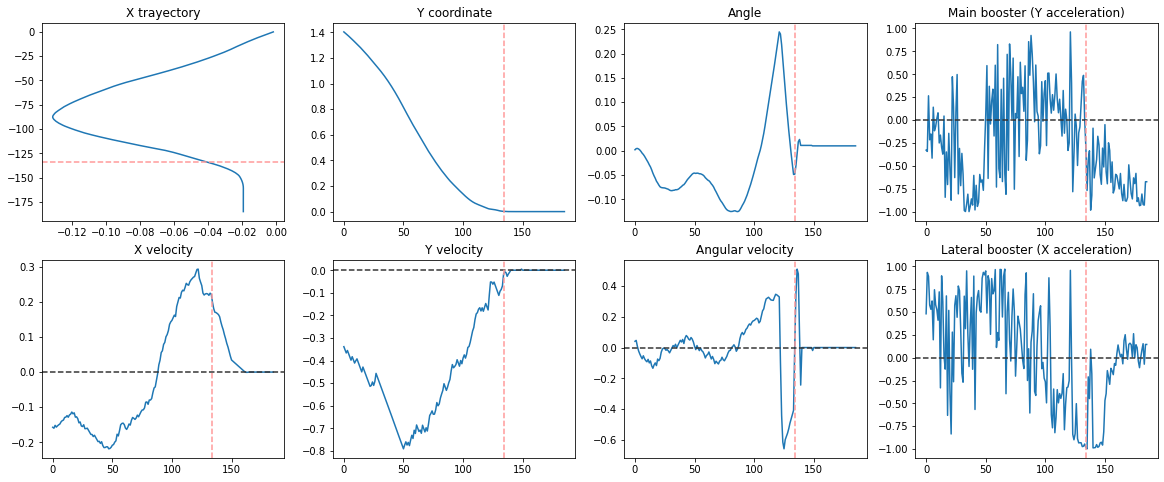

In [13]:
plotExperiment(exp1)

A diferencia del anterior experimento, en este podemos ver 
* por las lineas discontínuas rojas, que la nave ha tocado suelo con ambas piernas.
* Ambos X e Y don plausibles
* Las 3 velocidades quedan en 0

---

### Experimentos peculiares


In [22]:
expp1 = smoothY_pos(pd.read_csv("data/train/experiment_7.csv"))

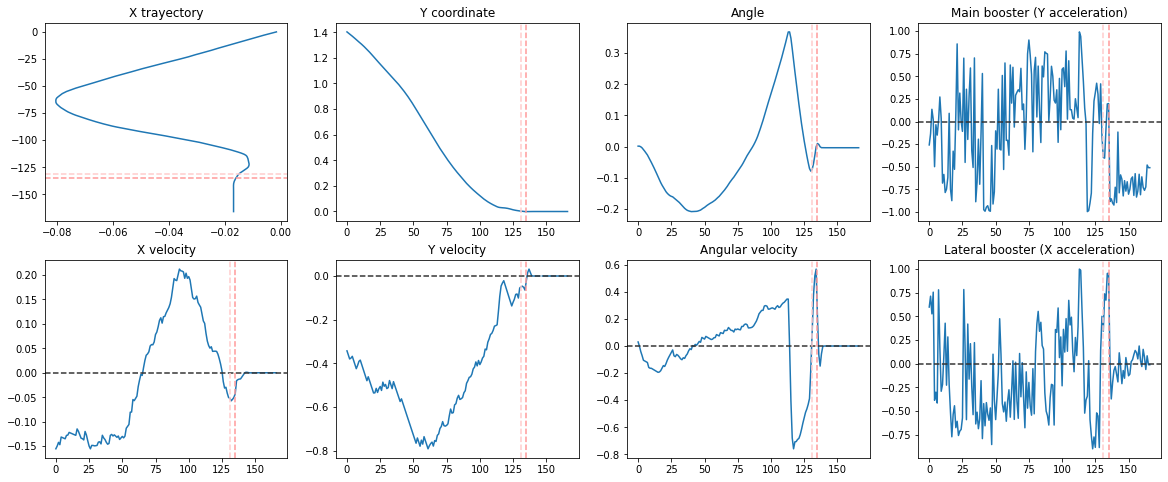

In [23]:
plotExperiment(expp1)